# Tutorial 10 - Applying fixation and blink detection results to gaze data
In this tutorial we will look at how to apply fixation and blink detection results
to exported gaze data. Afterward, we will know for each exported gaze sample if it
belongs to a fixation and/or a blink.

We will follow these steps:
1. Load the data using `Pandas`
1. For each fixation and blink, find and annotate the corresponding gaze data
    1. Select the start and end timestamp of the corresponding detection
    1. Find all gaze samples whose timestamps fall into that period
    1. Mark these gaze samples accordingly
1. Visualize the results

Please check the documentation of [Pupil Player](https://docs.pupil-labs.com/#pupil-player)
on how to detect blinks an fixations and how to export data.

This notebook is accompanied by a short example export. You can find it in the `data/10_apply_fixation_and_blink_detection_to_gaze` subfolder which contains the three files
that are important for this tutorial:

- `gaze_positions.csv`
- `blinks.csv`
- `fixations.csv`

## 1 - Loading Exported Data
Let's start by importing the necessary Python modules and loading the exported data.

In [1]:
import pandas as pd
import seaborn as sns

sns.set()


In [2]:
export_folder = "data/10_apply_fixation_and_blink_detection_to_gaze/"
gaze = pd.read_csv(export_folder + "gaze_positions.csv")
blinks = pd.read_csv(export_folder + "blinks.csv")
fixations = pd.read_csv(export_folder + "fixations.csv")


### Gaze data

You can find information on how the exported gaze data looks like in our previous tutorials.
Below, we only preview the data that is necessary for the blink and fixation matching:
The `gaze_timestamp` field.

In [3]:
gaze["gaze_timestamp"].head(3)  # .head(n): only display the first n entries


0    329367.897894
1    329367.905404
2    329367.907907
Name: gaze_timestamp, dtype: float64

### Blink data

The exported section contains three blinks of which we will need the `id`,
`start_timestamp`, and `end_timestamp`.

**Note**: The blink ids do not start at 0 or 1 because the exported data only represents
a short slice of a longer recording.

In [4]:
blinks[["id", "start_timestamp", "end_timestamp"]]  # only display the desired columns


,id,start_timestamp,end_timestamp
0,5,329368.551824,329368.927313
1,6,329372.045221,329372.495808
2,7,329373.668492,329374.104060


### Fixation data

In contrast to the blinks, the exported fixations do not have an `end_timestamp` field.
We can calculate the corresponding values by summing the `start_timestamp` and `duration`
values.

**Note**: `duration` is in milliseconds.

In [5]:
fixations[["id", "start_timestamp", "duration"]].head(3)


,id,start_timestamp,duration
0,65,329367.872861,202.7645
1,66,329368.078129,172.7250
2,67,329368.308429,172.7250


In [6]:
fixations["end_timestamp"] = fixations.start_timestamp + fixations.duration / 1_000

fixations[["id", "start_timestamp", "end_timestamp"]].head(3)  # display result


,id,start_timestamp,end_timestamp
0,65,329367.872861,329368.075625
1,66,329368.078129,329368.250853
2,67,329368.308429,329368.481154


## 2 - Find gaze data for each fixation and blink

We will save the matching blink and fixation ids for each gaze sample in a dedicated
column. To start, we set this column to `None` to indicate that the samples are neither
a blink nor a fixation.

In [28]:
gaze["blink_id"] = None
gaze["fixation_id"] = None


Next, we iterate over all blinks and fixations, extract their start and end timestamps,
and find the corresponding gaze samples.

For this, we use [`pandas.Series.between()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.between.html).

In [29]:
for blink in blinks.itertuples():
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.between.html
    # Return boolean Series equivalent to left <= series <= right.
    # `found_sample_mask` has the size as `gaze` and is True for all gaze samples
    # whose `gaze_timestamp` lies between the blink start end end time.
    found_sample_mask = gaze.gaze_timestamp.between(
        blink.start_timestamp, blink.end_timestamp
    )
    gaze.loc[found_sample_mask, "blink_id"] = blink.id

    # To count the found samples, we sum the boolean values (True = 1, False = 0).
    num_samples = found_sample_mask.sum()
    print(f"Found {num_samples} gaze samples for blink {blink.id}")


Found 124 gaze samples for blink 5
Found 121 gaze samples for blink 6
Found 117 gaze samples for blink 7


In [30]:
for fixation in fixations.itertuples():
    # Here we repeat the procedure
    found_sample_mask = gaze.gaze_timestamp.between(
        fixation.start_timestamp, fixation.end_timestamp
    )
    gaze.loc[found_sample_mask, "fixation_id"] = fixation.id


## 3 - Visualize results

### Blinks

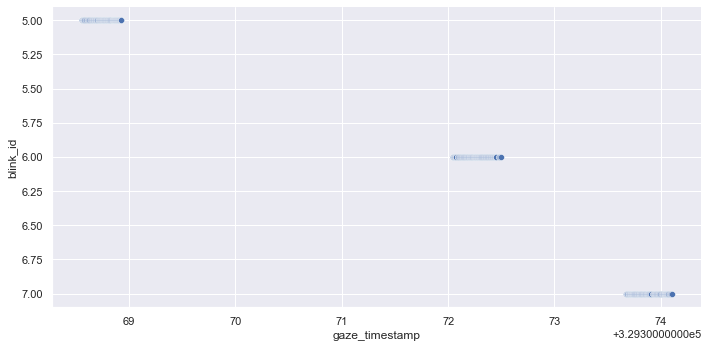

In [37]:
sns.relplot(data=gaze, x="gaze_timestamp", y="blink_id", aspect=2)


### Fixations

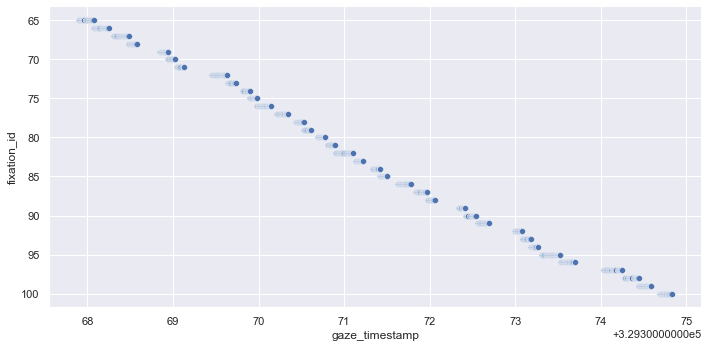

In [34]:
sns.relplot(data=gaze, x="gaze_timestamp", y="fixation_id", aspect=2)
